- In the previous lessons, you looked at building a binary classifier that predicted cats versus dogs or horses versus humans. You also saw how overfitting can occur and explored some practices for avoiding it. The problem with these of course, is that the training data was very small, and there's only so many common features that can be extracted, even if we do some tricks like image augmentation. 

- In both these cases, you built the model from scratch. What if you could take an existing model that's trained on far more data, and use the features that that model learned? That's the concept of transfer learning

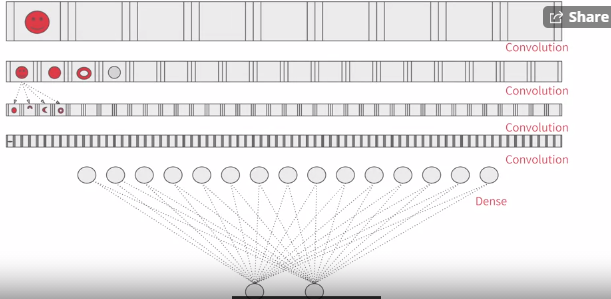

- So for example, if you visualize your model like this with a series of convolutional layers before dense layer leads your output layer, you feed your data into the top layer, the network learns the convolutions that identify the features in your data and all that. But consider somebody else's model, perhaps one that's far more sophisticated than yours, trained on a lot more data. They have convolutional layers and they're here intact with features that have already been learned. So you can lock them instead of retraining them on your data, and have those just extract the features from your data using the convolutions that they've already learned. 


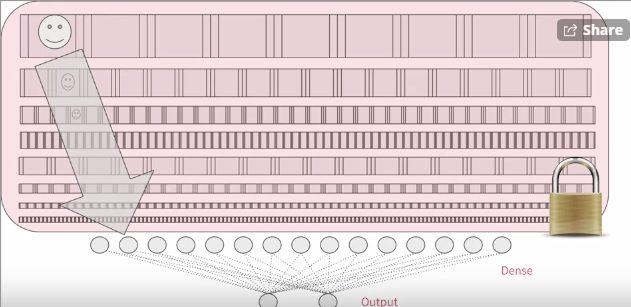

- Then you can take a model that has been trained on a very large datasets and use the convolutions that it learned when classifying its data. 

-If you recall how convolutions are created and used to identify particular features, and the journey of a feature through the network, it makes sense to just use those, and then retrain the dense layers from that model with your data. Of course, well, it's typical that you might lock all the convolutions. You don't have to. You can choose to retrain some of the lower ones too because they may be too specialized for the images at hand.

- It takes some trial and error to discover the right combination. So let's take a well-trained state of the art model. There's one called Inception, which you can learn more about at his site. This has been pre-trained on a dataset from ImageNet, which has 1.4 million images in a 1000 different classes.

we'll be using the keras layers API, to pick at the layers, and to understand which ones we want to use, and which ones we want to retrain. 

In [16]:
import os
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model


A copy of the pretrained weights for the inception neural network is saved at this URL. Think of this as a snapshot of the model after being trained. 

In [17]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

- It's the parameters that can then get loaded into the skeleton of the model, to turn it back into a trained model. So now if we want to use inception, it's fortunate that keras has the model definition built in.

-  you instantiate that with the desired input shape for your data, and specify that you don't want to use the built-in weights, but the snapshot that you've just downloaded.

-  The inception V3 has a fully-connected layer at the top. So by setting include_top to false, you're specifying that you want to ignore this and get straight to the convolutions. 

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150,150,3),include_top = False,weights = None)     #not using built in weight, but the snapshot we just downloaded

pre_trained_model.load_weights(local_weights_file)

Now that I have my pretrained model instantiated, I can iterate through its layers and lock them, saying that they're not going to be trainable with this code. 

In [9]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [11]:
# Predicting huge summary of model :

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

we saw how to take the layers from an existing model, and make them so that they don't get retrained -- i.e. we freeze (or lock) the already learned convolutions into our model. 

**Coding your own model with transferred features**

- All of the layers have names, so you can look up the name of the last layer that you want to use. If you inspect the summary, you'll see that the bottom layers have convolved to 3 by 3. 

But I want to do something interesting with a little more information. So I moved up the model description to find mixed7, (instead of mixed10 )which is the output of a lot of convolution that are 7 by 7.

You don't have to use this layer and is fun to experiment with others. But with this code, I'm going to grab that layer from inception and take it to output.


**Using Mixed7 layer for Fun**:


In [12]:
from tensorflow.keras.optimizers import RMSprop

last_layer = pre_trained_model.get_layer("mixed7")
last_output = last_layer.output

So now we'll define our new model, taking the output from the inception model's mixed7 layer, which we had called last_ouput.

This should look exactly like the dense models that you created way back at the start of this course. The code is a little different, but this is just a different way of using the layers API. 

- You start by flattening the input, which just happens to be the output from inception. 
- And then add a Dense hidden layer. 
- And then your output layer which has just one neuron activated by a sigmoid to classify between two items. 

- You can then create a model using the Model abstract class. And passing at the input and the layers definition that you've just created.

In [13]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation="relu")(x)
x = layers.Dense(1,activation="sigmoid")(x)

model = Model(pre_trained_model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# augment the images with the image generator

train_datagen = ImageDataGenerator(rescale = 1/255,rotation_range= 40 , 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2 , 
                                   sheer_range = 0.2, 
                                   zoom_range = 0.2 ,
                                   horizontal_flip = True)

In [ ]:
# get our training data from the generator by flowing from the specified directory and going through all the augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 20,
    class_mode = "binary",
    target_size = (150,150))

In [ ]:
#Train using model.fit generator

history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_steps = 50,
    verbose = 2
)

**USING DROPOUTS:**

we saw how to do transfer learning. But when we retrain the inception classifier features for cats versus dogs, we ended up over-fitting again. We also had augmentation, but despite that, we still suffered from over-fitting

The idea behind Dropouts is that they remove a random number of neurons in your neural network. This works very well for two reasons: The first is that neighboring neurons often end up with similar weights, which can lead to overfitting, so dropping some out at random can remove this. The second is that often a neuron can over-weigh the input from a neuron in the previous layer, and can over specialize as a result. Thus, dropping out can break the neural network out of this potential bad habit! 


There's another layer take in Keras called a dropout. And the idea behind the dropout is that layers in a neural network can sometimes end up having similar weights and possible impact each other leading to over-fitting. With a big complex model like this, that's a risk. So if you can imagine the dense layers can look a little bit like this.

By dropping some out, we make it look like this. And that has the effect of neighbors not affecting each other too much and potentially removing overfitting.

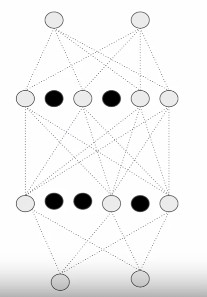

In [ ]:
#Code implementation for Dropout:

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1,activation="sigmoid")(x)

model = Model(pre_trained_model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

The parameter is between 0 and 1 and it's the fraction of units to drop.
In this case, we're dropping out 20% of our neurons. 